# Goals
The objective of these notebooks is to parse a video-extracted png map. Say Europe 1918 : ![Europe 1918](input/europe_1918.png)
Into an SVG file, with automatic country name detection

## Steps
Here are the main steps to be taken in order to achieve these goals
1. Extract all countries' shapes
2. Extract countries' names and label the countries accordingly

## 1. Countries' shapes extraction
The notebook [Polygon extraction](polygon_extraction.ipynb) details how the polygons are extracted, and stores them.  
Here is the extracted (vector map) of europe

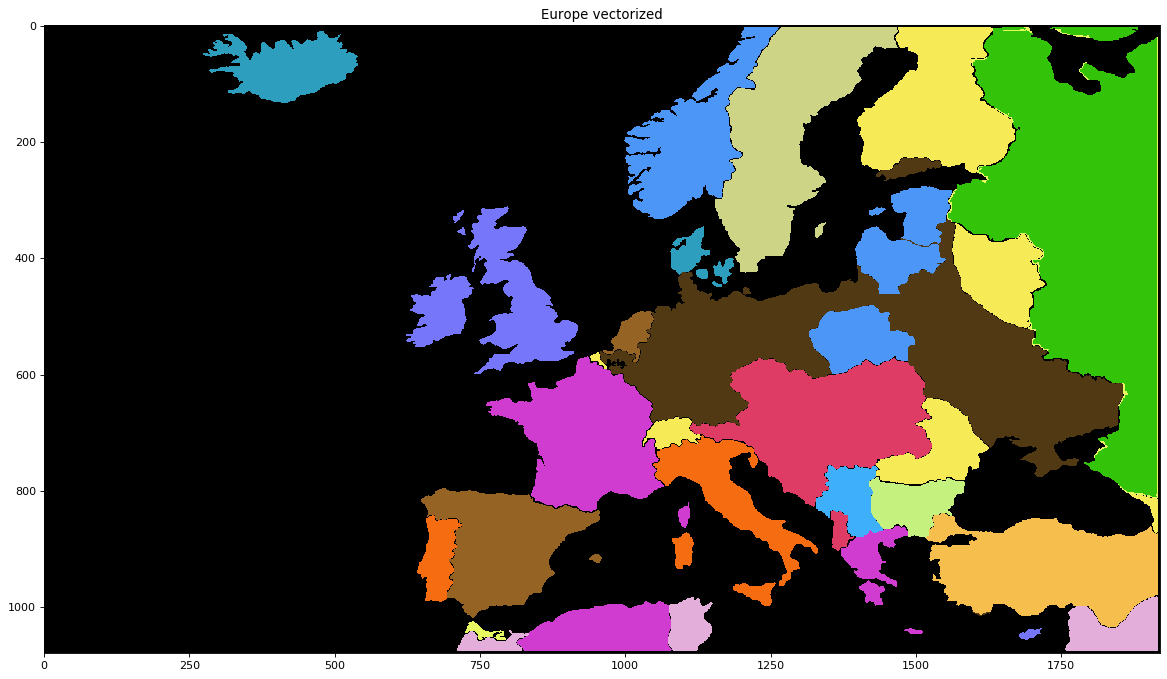

In [41]:
import os
import shapely.wkt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import skimage.draw

def load_polygons(folder):
    files = os.listdir(folder)
    res = {}
    for filename in files :
        path = os.path.join(folder, filename)
        with open(path, 'r') as wkt_file :
            polygon = shapely.wkt.loads(wkt_file.read()) 
        colour_code = filename.split('_')[0]
        try:
            res[colour_code]
        except KeyError:
            res[colour_code] = []
        res[colour_code].append(polygon)
    return [res[index] for index in res]

def draw_polygons(img, polygons, color):
    res = img.copy()
    for polygon in polygons :
        coords = np.array(polygon.exterior.coords)
        rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
        res[rr, cc] = color
    return res

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

polygons = load_polygons('tmp/wkt')

europe = plt.imread('input/europe_1918.png')[:, :, :3]
europe_vector = np.zeros(europe.shape).astype(int)
for i, countryset in tqdm(enumerate(polygons), total=len(polygons)):
    europe_vector = draw_polygons(europe_vector, countryset, np.random.choice(range(256), size=3))

display_img(europe_vector, 'Europe vectorized', True)

Then, an automatic country naming can be performed. Due to OCR difficulties, the result will need corrections. But a significant part of the labelling work can be performed beforehand. Take a look at the notebook [Country labelling](country_labelling.ipynb) for more details about the process.

## 2. Text extraction with tesseract
Using the cleaned image of Europe generated in the [Polygon Extraction notebook](polygon_extraction.ipynb)

Here is what the naming algorithm is capable of so far : 
![Europe countries labelled](output/europe_labelled.png)

## 3. Rescale the vector polygons to fit in the world map
An algorithm was developed to automatically detect the position of europe in the world map. It is detailed in the notebook [Image Locator](image_locator.ipynb)  
The code below does the scaling and add an offset to every polygon so they fit in our world map.  

(1550, 2269, 3)
Scaling the countries with a scale factor =  0.25664364984375


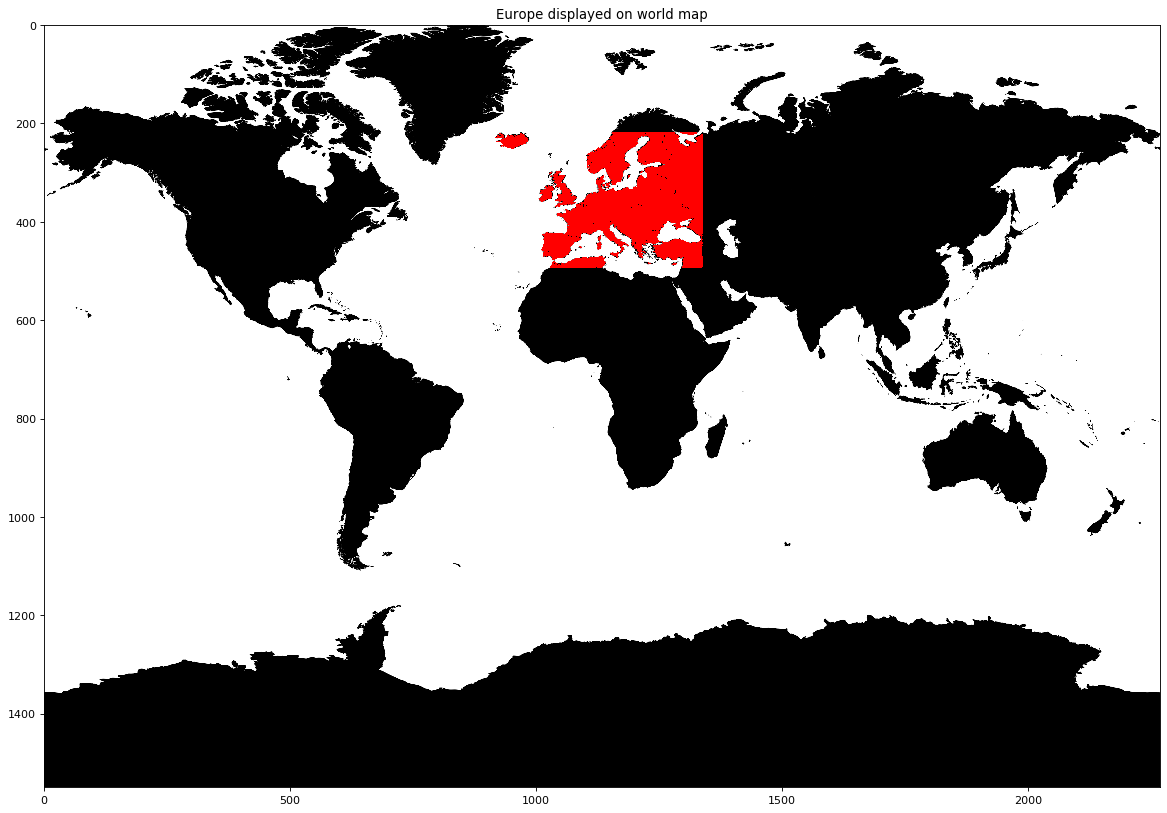

In [40]:
from shapely import affinity

polygons_frame = (1920, 1080)
polygons_frame_on_wmap = (492.7558077, 158.58236733760293)
polygons_offset_on_wmap = (846.2237043, 217.87344922232387)
world_map_frame = (2269.4568,  1550.3625)
def load_countries(folder):
    files = os.listdir(folder)
    res = []
    for filename in files :
        path = os.path.join(folder, filename)
        if filename.endswith('.wkt') and not 'scaled'in filename :
            with open(path, 'r') as wkt_file :
                polygon = shapely.wkt.loads(wkt_file.read()) 
            res.append({'filename' : filename, 'shape' : polygon})
    return res

def save_country(folder, filename, shape) :
    path = os.path.join(folder, filename)
    with open(path, 'w') as wkt_file :
        wkt_file.write(shapely.wkt.dumps(shape))


scale_factor = polygons_frame_on_wmap[0] / polygons_frame[0]
world_map = skimage.color.rgba2rgb(plt.imread('input/world_small.png'))
print(world_map.shape)

countries = load_countries('output/country_naming')
print('Scaling the countries with a scale factor = ', scale_factor)
for country in tqdm(countries):
    scaled = affinity.scale(country['shape'], scale_factor, scale_factor, origin=(0, 0))
    scaled = affinity.translate(scaled, polygons_offset_on_wmap[0], polygons_offset_on_wmap[1])
    world_map = draw_polygons(world_map, [scaled], (1, 0, 0))
    filename = os.path.splitext(country['filename'])[0] + '_scaled.wkt'
    save_country('output/country_naming', filename, scaled)
display_img(world_map, 'Europe displayed on world map', True)

## Conclusion
This research phase allowed countries countouring and labelling. The program using these algorithms to parse maps is written at the root of the github's project. A next step will be to parse a whole video (thus adding a time dimension to every map).